In [1]:
# !kaggle datasets download -d andrewmvd/face-mask-detection
# !jar xf face-mask-detection.zip

In [1]:
import numpy as np
import pandas as pd
import os
import xml.etree.ElementTree as  et
import pathlib
import glob
from shutil import copyfile

import cv2
import tensorflow as tf

In [13]:
tree = et.parse('annotations/' + os.listdir('annotations/')[0])
root = tree.getroot()
for i in root.iter('xmin'):
    print(i.text)
    
for i in root.iter('bndbox'):
    print(i.find('xmin').text)
    print(i.find('ymin').text)

79
185
325
79
105
185
100
325
90


## Creating Cropped Images and CSV

In [21]:
df = pd.read_csv('cropped_classes.csv')
df.head()

,Unnamed: 0,img_id,class
0,0,maksssksksss0_0,without_mask
1,1,maksssksksss0_1,with_mask
2,2,maksssksksss0_2,without_mask
3,3,maksssksksss1_0,with_mask
4,4,maksssksksss1_1,with_mask


In [39]:
int(df.__len__()*0.8)

3257

In [44]:
# for i in df.values[:1]:
#     print(i)
#     copyfile('cropped/'+i[1]+'.jpg', 'train/'+i[2]+'/'+i[1]+'.jpg')

## Generator

In [2]:
train_dg = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True
)

test_dg = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [74]:
train_gen = train_dg.flow_from_directory(
    'train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = train_dg.flow_from_directory(
    'test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3257 images belonging to 3 classes.
Found 815 images belonging to 3 classes.


In [75]:
train_gen.class_indices, test_gen.class_indices

({'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2},
 {'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2})

In [92]:
resnet = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in resnet.layers:
    layer.trainable = False

94674944/94668760 [==============================] - 22s 0us/step


In [93]:
x = tf.keras.layers.Flatten()(resnet.output)
pred_layer = tf.keras.layers.Dense(3, activation='softmax')(x)

In [94]:
model = tf.keras.models.Model(inputs=resnet.input, outputs=pred_layer)
# model.summary()

In [95]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [96]:
history = model.fit(train_gen, validation_data=test_gen, epochs=5, steps_per_epoch=50)

Epoch 1/5
50/50 [==============================] - 27s 484ms/step - loss: 3.3108 - accuracy: 0.7621 - val_loss: 1.2569 - val_accuracy: 0.9166
Epoch 2/5
50/50 [==============================] - 23s 459ms/step - loss: 1.0047 - accuracy: 0.9159 - val_loss: 1.4752 - val_accuracy: 0.8847
Epoch 3/5
50/50 [==============================] - 23s 462ms/step - loss: 0.9390 - accuracy: 0.9182 - val_loss: 0.9459 - val_accuracy: 0.9153
Epoch 4/5
50/50 [==============================] - 24s 479ms/step - loss: 1.1111 - accuracy: 0.9056 - val_loss: 1.2075 - val_accuracy: 0.9215
Epoch 5/5
50/50 [==============================] - 24s 483ms/step - loss: 1.0215 - accuracy: 0.9294 - val_loss: 1.2592 - val_accuracy: 0.9104


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

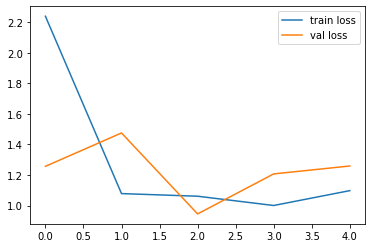

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

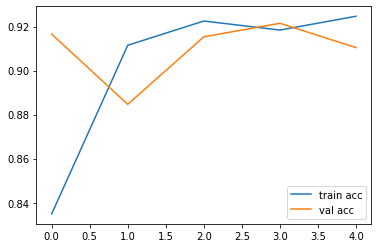

In [97]:
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label = 'train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

In [98]:
# model.save('models/resnet50v2.h5')